## Description

Reduce the time a Mercedes-Benz spends on the test bench.

### Problem Statement Scenario:
Since the first automobile, the Benz Patent Motor Car in 1886, Mercedes-Benz has stood for important automotive innovations. These include the passenger safety cell with the crumple zone, the airbag, and intelligent assistance systems. Mercedes-Benz applies for nearly 2000 patents per year, making the brand the European leader among premium carmakers. Mercedes-Benz cars are leaders in the premium car industry. With a huge selection of features and options, customers can choose the customized Mercedes-Benz of their dreams.

To ensure the safety and reliability of every unique car configuration before they hit the road, Daimler’s engineers have developed a robust testing system. As one of the world’s biggest manufacturers of premium cars, safety and efficiency are paramount on Daimler’s production lines. However, optimizing the speed of their testing system for many possible feature combinations is complex and time-consuming without a powerful algorithmic approach.

You are required to reduce the time that cars spend on the test bench. Others will work with a dataset representing different permutations of features in a Mercedes-Benz car to predict the time it takes to pass testing. Optimal algorithms will contribute to faster testing, resulting in lower carbon dioxide emissions without reducing Daimler’s standards.

### Following actions should be performed:
* If for any column(s), the variance is equal to zero, then you need to remove those variable(s).
* Check for null and unique values for test and train sets
* Apply label encoder.
* Perform dimensionality reduction.
* Predict your test_df values using xgboost

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

**Exploring train data**

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


In [4]:
### Exploring data type float which turns out to be our y - target
train.select_dtypes('float').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       4209 non-null   float64
dtypes: float64(1)
memory usage: 33.0 KB


**Separating y values from train df**

In [5]:
# Checking for target values
for i in train.columns:
    if i not in test.columns:
        print("The Target variable is {}".format(i))

The Target variable is y


In [6]:
Y_train= train.y.to_frame()
Y_train.shape

(4209, 1)

In [7]:
# check for nulls
Y_train.isnull().sum()

y    0
dtype: int64

In [8]:
# Lets check for skewness
Y_train.skew()

y    1.206526
dtype: float64

<AxesSubplot:ylabel='Count'>

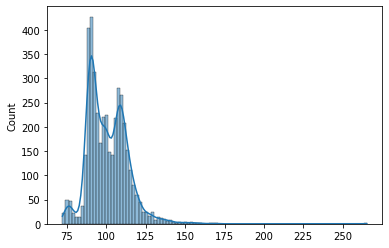

In [9]:
# Lets plot to visualize skewness
plt.figure(figsize=(6,4))
sns.histplot(Y_train, bins=100, kde=True, legend=False )

<AxesSubplot:>

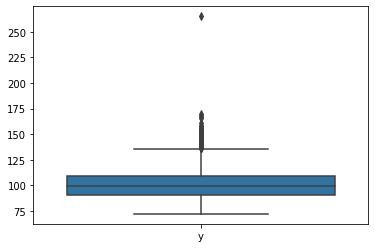

In [10]:
# Lets look into the outliers
plt.figure(figsize=(6,4))
sns.boxplot(data = Y_train)

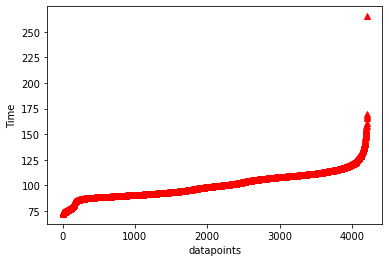

In [11]:
plt.plot(sorted(Y_train.values),'r^')
plt.xlabel("datapoints")
plt.ylabel("Time")
plt.show()

**Clearly, there is one data point which happened to be way higher compared to other data points.**

In [12]:
# Lets investigate further.
Y_train.describe().T

,count,mean,std,min,25%,50%,75%,max
y,4209.0,100.669318,12.679381,72.11,90.82,99.15,109.01,265.32


In [13]:
# Lets replace the max value with y mean.
Y_train = pd.DataFrame(np.where((Y_train>250),Y_train.mean(), Y_train))
Y_train.describe().T

,count,mean,std,min,25%,50%,75%,max
0,4209.0,100.630199,12.42267,72.11,90.82,99.15,109.01,169.91


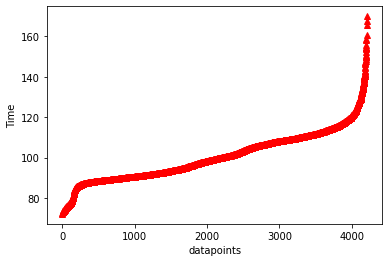

In [14]:
# Our max values has been replaced and now lets plot it again
plt.plot(sorted(Y_train.values),'r^')
plt.xlabel("datapoints")
plt.ylabel("Time")
plt.show()

In [15]:
# Lets check how many points are out of range

Q1 = Y_train.quantile(0.25)
Q3 = Y_train.quantile(0.75)
IQR = Q3-Q1
lower_limit=Q1-1.5*IQR
upper_limit=Q3+1.5*IQR
Y_mod = (Y_train < (Q1 - 1.5 * IQR)) |(Y_train > (Q3 + 1.5 * IQR))
Y_mod.value_counts()

False    4160
True       49
dtype: int64

 **This means out of 4209 data points, 49 points are out of range, meaning either lower or above our lower & upper limit which were calculated as above.**

Text(0.5, 1.0, 'CDF Distributions')

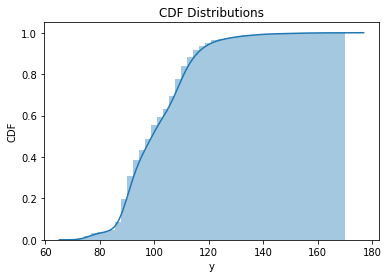

In [16]:
#https://stackoverflow.com/questions/39297523/plot-cdf-cumulative-histogram-using-seaborn-python

x = Y_train.values
kwargs = {'cumulative': True}
plt.figure(figsize=(6,4))
sns.distplot(x, hist_kws=kwargs, kde_kws=kwargs)
plt.xlabel("y")
plt.ylabel("CDF")
plt.title("CDF Distributions")

**This shows that 95% of the output variable lies less than 120 and very few data points lie beyond the range of 150.**

In [17]:
above_150 = Y_train[Y_train>150].value_counts()
above_150

150.43    1
150.89    1
152.32    1
153.51    1
154.16    1
154.43    1
154.87    1
155.62    1
158.23    1
158.53    1
160.87    1
165.52    1
167.45    1
169.91    1
dtype: int64

In [18]:
# Replacing values above 150 to Y mean
Y_train = pd.DataFrame(np.where((Y_train>150),Y_train.mean(), Y_train))
Y_train.shape

(4209, 1)

<AxesSubplot:ylabel='Count'>

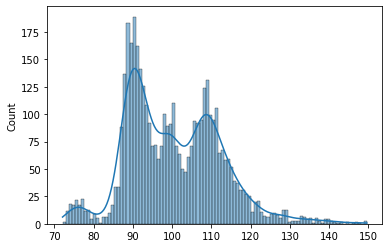

In [19]:
# Lets visualize the data distribution of Y after handling the outliers
plt.figure(figsize=(6,4))
sns.histplot(Y_train, bins=100, kde=True, legend=False )

In [20]:
Y_train.shape

(4209, 1)

In [21]:
### Exploring data type int
train.select_dtypes('int').describe().T

,count,mean,std,min,25%,50%,75%,max
ID,4209.0,4205.960798,2437.608688,0.0,2095.0,4220.0,6314.0,8417.0
X10,4209.0,0.013305,0.114590,0.0,0.0,0.0,0.0,1.0
X11,4209.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
X12,4209.0,0.075077,0.263547,0.0,0.0,0.0,0.0,1.0
X13,4209.0,0.057971,0.233716,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
X380,4209.0,0.008078,0.089524,0.0,0.0,0.0,0.0,1.0
X382,4209.0,0.007603,0.086872,0.0,0.0,0.0,0.0,1.0
X383,4209.0,0.001663,0.040752,0.0,0.0,0.0,0.0,1.0
X384,4209.0,0.000475,0.021796,0.0,0.0,0.0,0.0,1.0


In [22]:
train.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   X0      4209 non-null   object
 1   X1      4209 non-null   object
 2   X2      4209 non-null   object
 3   X3      4209 non-null   object
 4   X4      4209 non-null   object
 5   X5      4209 non-null   object
 6   X6      4209 non-null   object
 7   X8      4209 non-null   object
dtypes: object(8)
memory usage: 263.2+ KB


In [23]:
# Object category visualization

object_df = train.select_dtypes('object')
object_df['y'] = Y_train
pd.DataFrame(object_df)

,X0,X1,X2,X3,X4,X5,X6,X8,y
0,k,v,at,a,d,u,j,o,130.81
1,k,t,av,e,d,y,l,o,88.53
2,az,w,n,c,d,x,j,x,76.26
3,az,t,n,f,d,x,l,e,80.62
4,az,v,n,f,d,h,d,n,78.02
...,...,...,...,...,...,...,...,...,...
4204,ak,s,as,c,d,aa,d,q,107.39
4205,j,o,t,d,d,aa,h,h,108.77
4206,ak,v,r,a,d,aa,g,e,109.22
4207,al,r,e,f,d,aa,l,u,87.48


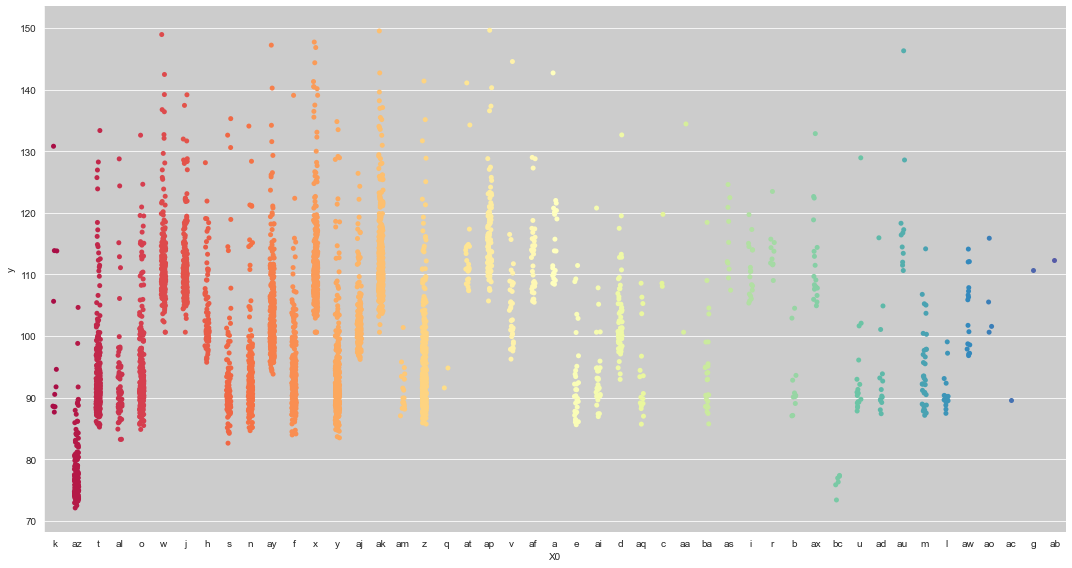

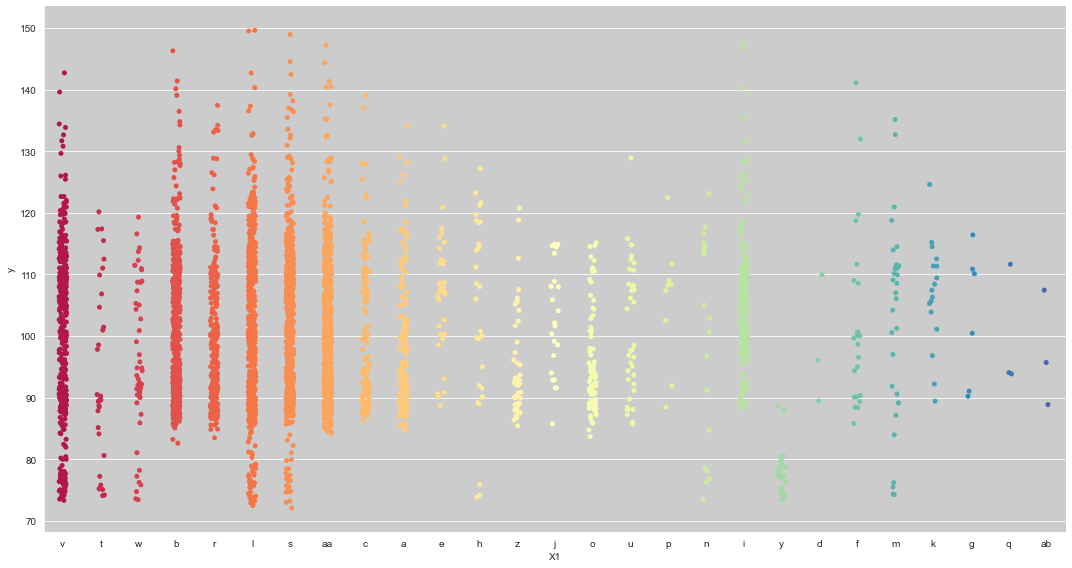

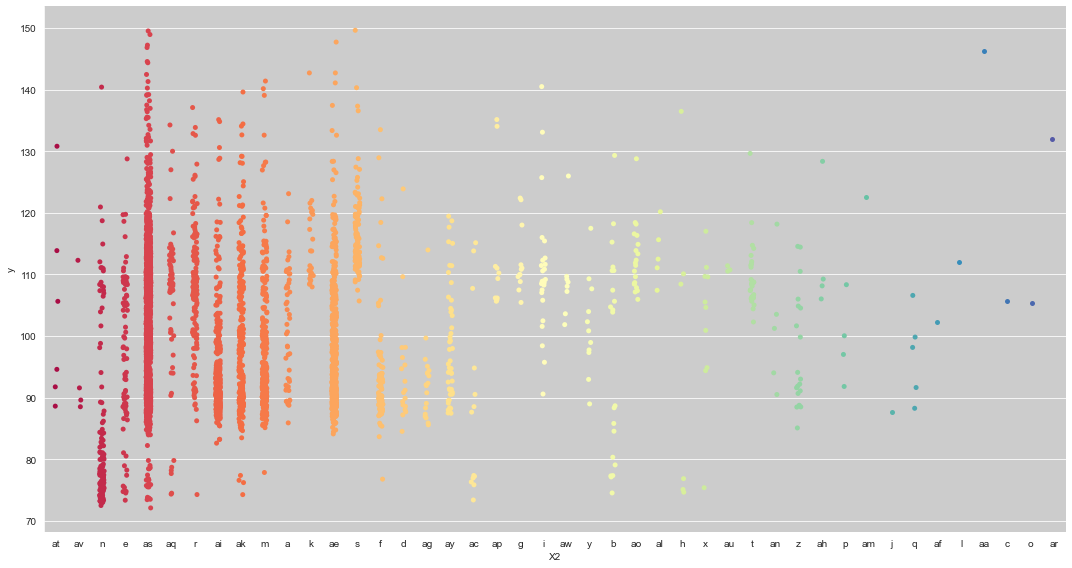

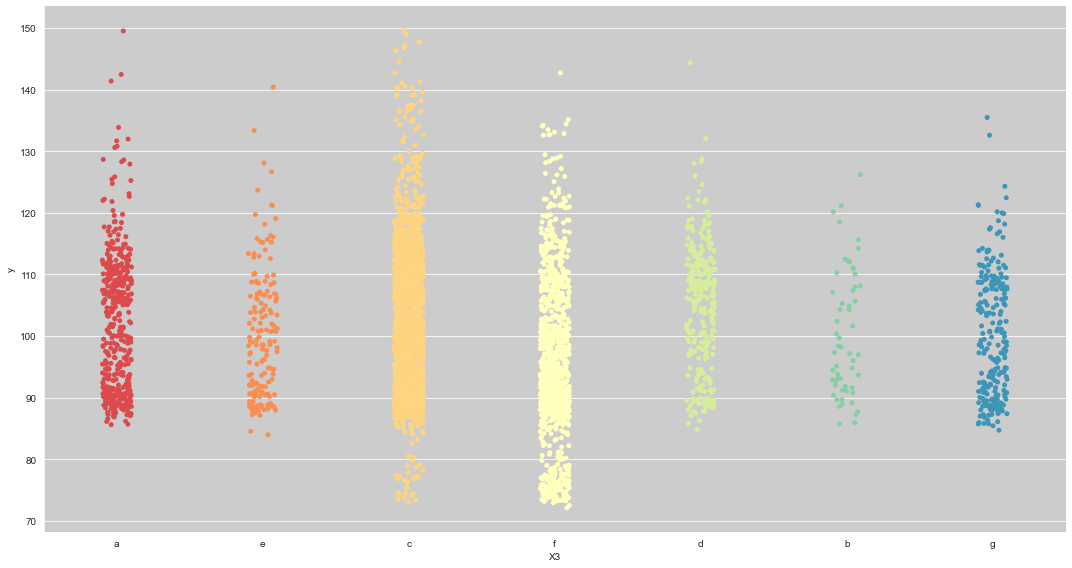

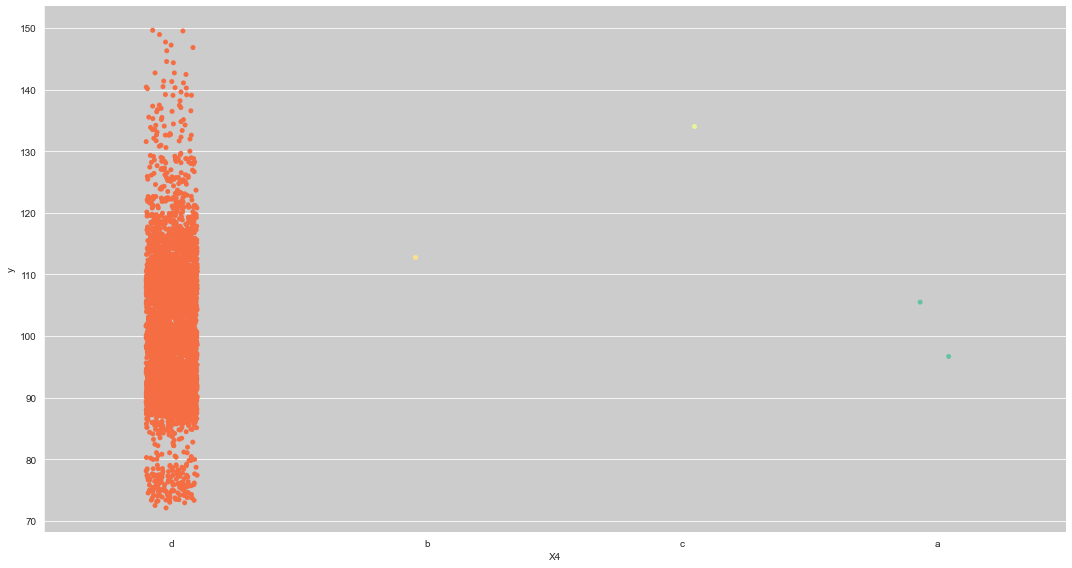

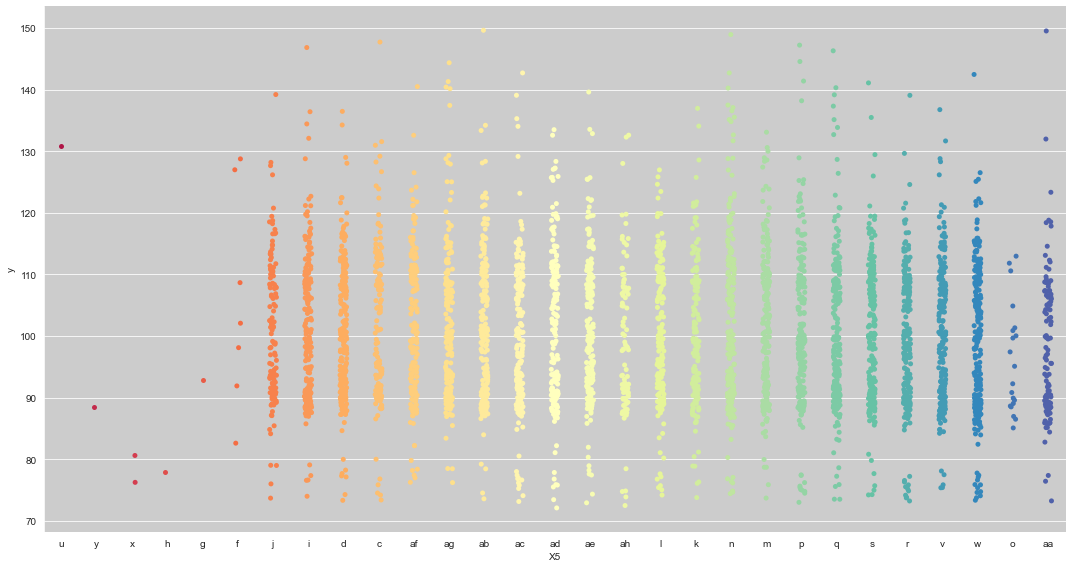

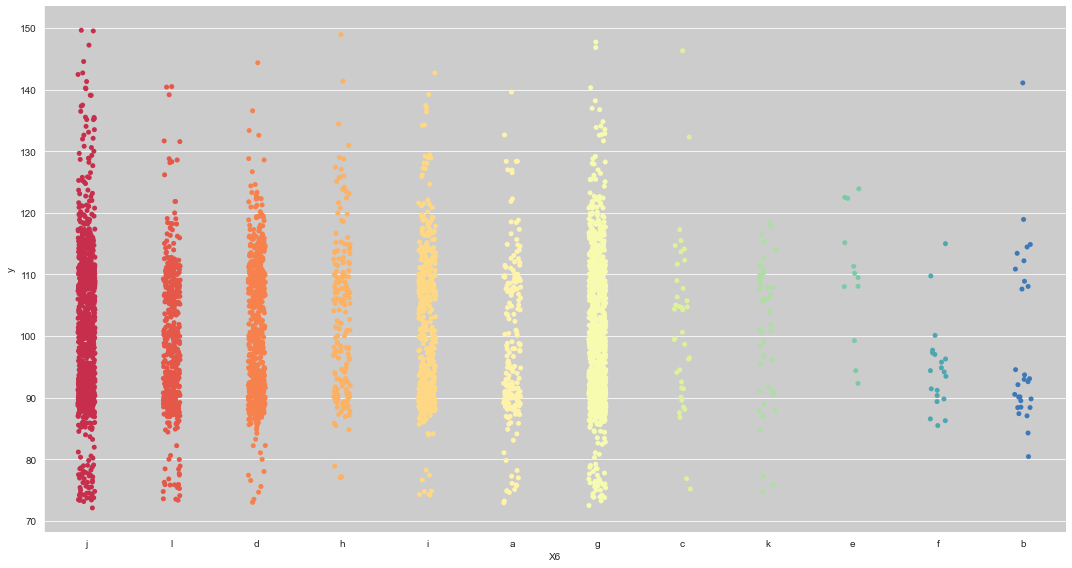

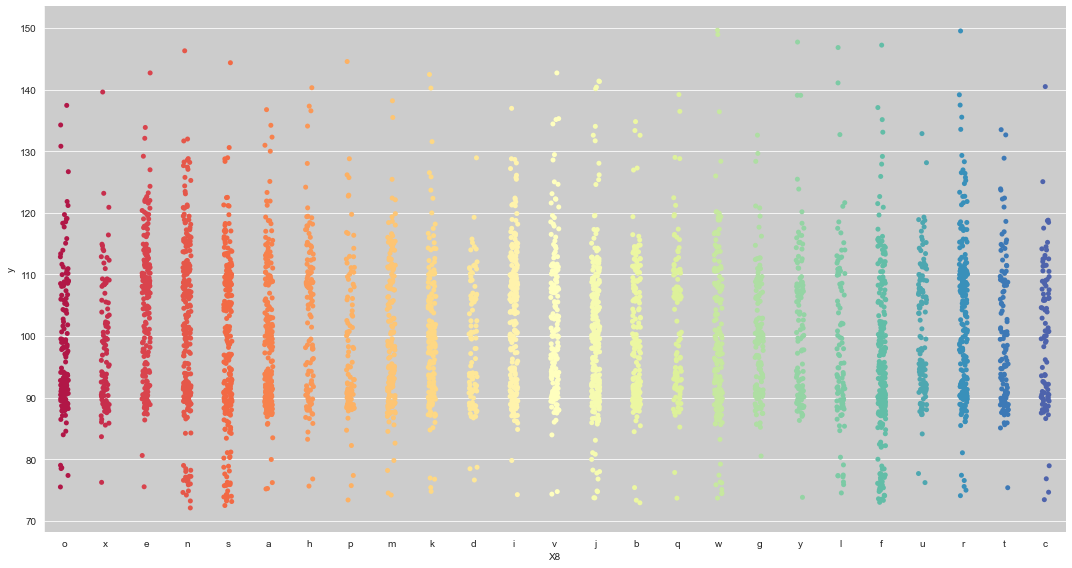

In [24]:
#### Plot some graphs for cat. variables and y mean.
sns.set_style("darkgrid", {"axes.facecolor": ".8"})

cat='X0'
sns.catplot(x=cat, y="y", data=object_df,height=8, aspect=15/8, palette="Spectral")

cat='X1'
sns.catplot(x=cat, y="y", data=object_df,height=8, aspect=15/8, palette="Spectral")

cat='X2'
sns.catplot(x=cat, y="y", data=object_df,height=8, aspect=15/8, palette="Spectral")

cat='X3'
sns.catplot(x=cat, y="y", data=object_df,height=8, aspect=15/8, palette="Spectral")

cat='X4'
sns.catplot(x=cat, y="y", data=object_df,height=8, aspect=15/8, palette="Spectral")

cat='X5'
sns.catplot(x=cat, y="y", data=object_df,height=8, aspect=15/8, palette="Spectral")

cat='X6'
sns.catplot(x=cat, y="y", data=object_df,height=8, aspect=15/8, palette="Spectral")

cat='X8'
sns.catplot(x=cat, y="y", data=object_df,height=8, aspect=15/8, palette="Spectral")


In [25]:
## Explain about the graphs above, a few lines

In [26]:
# Checking for null values for confirmation:
train.isnull().sum().value_counts()

0    378
dtype: int64

In [27]:
test.isnull().sum().value_counts()

0    377
dtype: int64

**If for any column(s), the variance is equal to zero, then you need to remove those variable(s).**

In [28]:
# Variance is range-dependent, therefore we need to do normalization before applying this technique.

from sklearn.preprocessing import normalize

normalize = ((pd.DataFrame(normalize(train.select_dtypes('int')))).var().sort_values(ascending=False)==0).value_counts()
normalize
# Which means, there are 12 features with zero variance

False    357
True      12
dtype: int64

Text(0.5, 1.0, 'Features with zero variance')

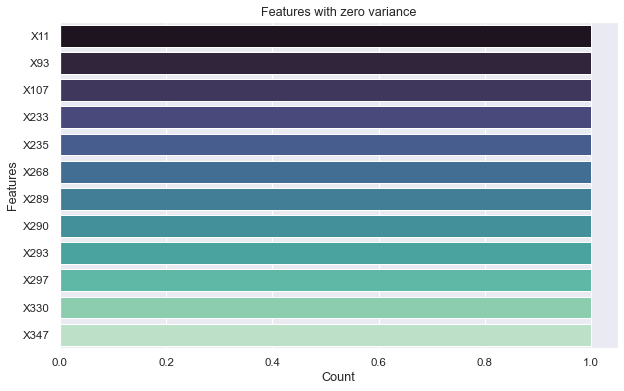

In [29]:
n_unique = train.select_dtypes(include=['int64']).nunique().reset_index().rename(columns={'index':'Features', 0 : 'Count'})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc = {'figure.figsize':(10,6)},font_scale = 1.05)
sns.barplot(x = 'Count',y = 'Features',data = n_unique.loc[n_unique['Count']==1], palette='mako')
plt.title('Features with zero variance')

In [30]:
pd.set_option('display.max_rows', None)
non_0_variance = n_unique.loc[n_unique['Count']>1]
non_0_variance.drop(index=non_0_variance.index[0],axis=0, inplace=True)
non_0_variance

,Features,Count
1,X10,2
3,X12,2
4,X13,2
5,X14,2
6,X15,2
7,X16,2
8,X17,2
9,X18,2
10,X19,2
11,X20,2


In [31]:
# Finding correlations
corr_df=train.corr()

In [32]:
# We can further drop the columns above:

# Train dataset
X_train = train.drop(columns=['X11','X93','X107','X233','X235','X268','X289','X290','X293','X297','X330','X347','y','ID'], axis=1)
# Test dataset
X_test = test.drop(columns=['X11','X93','X107','X233','X235','X268','X289','X290','X293','X297','X330','X347','ID'], axis=1)

In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 364 entries, X0 to X385
dtypes: int64(356), object(8)
memory usage: 11.7+ MB


In [34]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 364 entries, X0 to X385
dtypes: int64(356), object(8)
memory usage: 11.7+ MB


### Apply label encoder

In [35]:
X_train.select_dtypes('object').head()

,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n


In [36]:
from sklearn.preprocessing import LabelEncoder

In [37]:
# For train data set:

df_col_train=list(X_train.select_dtypes('object'))

for i in range(len(df_col_train)):
    le = LabelEncoder()
    X_train[df_col_train[i]] = le.fit_transform(X_train[df_col_train[i]])
    
# For test data set:

df_col_test=list(X_test.select_dtypes('object'))
for i in range(len(df_col_test)):
    le = LabelEncoder()
    X_test[df_col_test[i]] = le.fit_transform(X_test[df_col_test[i]])

In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 364 entries, X0 to X385
dtypes: int32(8), int64(356)
memory usage: 11.6 MB


In [39]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 364 entries, X0 to X385
dtypes: int32(8), int64(356)
memory usage: 11.6 MB


In [40]:
# decision tree for feature importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# create model
rf = RandomForestRegressor(n_estimators=150)

# fit the model
rf.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=150)

(-1.0, 50.0)

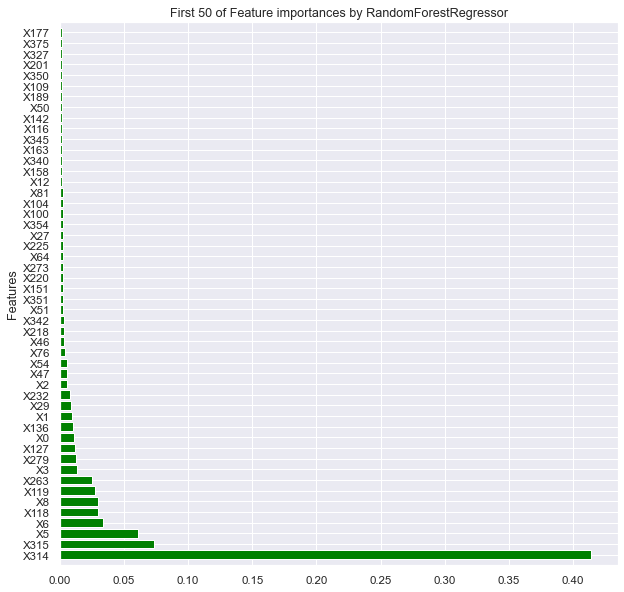

In [41]:
feat_names = X_train.columns.values
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:50]

# Visualize feature importance
plt.subplots(figsize=(10,10))
plt.title("First 50 of Feature importances by RandomForestRegressor")
plt.ylabel("Features")
plt.barh(range(len(indices)), importances[indices], color="green", align="center")
plt.yticks(range(len(indices)), feat_names[indices], rotation='horizontal')
plt.ylim([-1, len(indices)])

In [42]:
# Data Preprocessing
from sklearn.preprocessing import StandardScaler
X_train_sd = StandardScaler().fit_transform(X_train)
X_test_sd = StandardScaler().fit_transform(X_test)

### Perform dimensionality reduction.

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12, random_state=420)
pca_train = pca.fit_transform(X_train_sd)
pca_test = pca.transform(X_test_sd)

In [45]:
print(pca.explained_variance_ratio_)## shows percentage

[0.06892669 0.05688412 0.04537457 0.03426771 0.03264309 0.03162661
 0.02862524 0.02123745 0.01970394 0.01783161 0.01639552 0.01563831]


### Predict your test_df values using xgboost

In [46]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split

In [55]:
#X_train,X_test, Y_train, Y_test = train_test_split(pca_train,Y_train,test_size=0.2, random_state=420)